# **Import library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import os
import os.path
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.model_selection import train_test_split
import glob
from PIL import Image
import cv2
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
import torchvision.transforms as transforms


# Path Process

In [2]:
No_Data_Path = Path("/kaggle/input/brain-tumor-detection/no")
Yes_Data_Path = Path("/kaggle/input/brain-tumor-detection/yes")

In [3]:
No_Jpg_Path = list(No_Data_Path.glob(r"*.jpg"))
Yes_Jpg_Path = list(Yes_Data_Path.glob(r"*.jpg"))

In [4]:
print(No_Jpg_Path[:5])

[PosixPath('/kaggle/input/brain-tumor-detection/no/no26.jpg'), PosixPath('/kaggle/input/brain-tumor-detection/no/no979.jpg'), PosixPath('/kaggle/input/brain-tumor-detection/no/no598.jpg'), PosixPath('/kaggle/input/brain-tumor-detection/no/no141.jpg'), PosixPath('/kaggle/input/brain-tumor-detection/no/no715.jpg')]


In [5]:
Yes_No_list = []
for no_jpg in No_Jpg_Path:
    Yes_No_list.append(no_jpg)
    
for yes_jpg in Yes_Jpg_Path:
    Yes_No_list.append(yes_jpg)

In [6]:
JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Yes_No_list))

In [7]:
print(JPG_Labels[0:10])

['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']


In [8]:
print("No counting: ", JPG_Labels.count("no"))
print("Yes counting: ", JPG_Labels.count("yes"))

No counting:  1500
Yes counting:  1500


In [9]:
JPG_Path_Series = pd.Series(Yes_No_list, name = "jpg").astype(str)
JPG_Category_Series = pd.Series(JPG_Labels, name = "TUMOR_CATEGORY")

In [10]:
print(JPG_Path_Series[:5])
print(JPG_Category_Series[:5])

0     /kaggle/input/brain-tumor-detection/no/no26.jpg
1    /kaggle/input/brain-tumor-detection/no/no979.jpg
2    /kaggle/input/brain-tumor-detection/no/no598.jpg
3    /kaggle/input/brain-tumor-detection/no/no141.jpg
4    /kaggle/input/brain-tumor-detection/no/no715.jpg
Name: jpg, dtype: object
0    no
1    no
2    no
3    no
4    no
Name: TUMOR_CATEGORY, dtype: object


In [11]:
Main_Train_Data = pd.concat([JPG_Path_Series, JPG_Category_Series], axis = 1)
print(Main_Train_Data.head(-1))

                                                    jpg TUMOR_CATEGORY
0       /kaggle/input/brain-tumor-detection/no/no26.jpg             no
1      /kaggle/input/brain-tumor-detection/no/no979.jpg             no
2      /kaggle/input/brain-tumor-detection/no/no598.jpg             no
3      /kaggle/input/brain-tumor-detection/no/no141.jpg             no
4      /kaggle/input/brain-tumor-detection/no/no715.jpg             no
...                                                 ...            ...
2994   /kaggle/input/brain-tumor-detection/yes/y136.jpg            yes
2995  /kaggle/input/brain-tumor-detection/yes/y1379.jpg            yes
2996  /kaggle/input/brain-tumor-detection/yes/y1452.jpg            yes
2997   /kaggle/input/brain-tumor-detection/yes/y378.jpg            yes
2998   /kaggle/input/brain-tumor-detection/yes/y178.jpg            yes

[2999 rows x 2 columns]


In [12]:
Prediction_Path = Path("/kaggle/input/brain-tumor-detection/pred")

In [13]:
Test_JPG_Path = list(Prediction_Path.glob(r"*.jpg"))

In [14]:
print(Test_JPG_Path[:5])

[PosixPath('/kaggle/input/brain-tumor-detection/pred/pred35.jpg'), PosixPath('/kaggle/input/brain-tumor-detection/pred/pred3.jpg'), PosixPath('/kaggle/input/brain-tumor-detection/pred/pred56.jpg'), PosixPath('/kaggle/input/brain-tumor-detection/pred/pred46.jpg'), PosixPath('/kaggle/input/brain-tumor-detection/pred/pred39.jpg')]


In [15]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [16]:
print(Test_JPG_Labels[:5])

['pred', 'pred', 'pred', 'pred', 'pred']


In [17]:
Test_JPG_Path_Series = pd.Series(Test_JPG_Path, name = "jpg").astype(str)
Test_JPG_Labels_Series = pd.Series(Test_JPG_Labels, name = "TUMOR_CATEGORY")

In [18]:
Test_Data = pd.concat([Test_JPG_Path_Series, Test_JPG_Labels_Series], axis = 1)
print(Test_Data.head())

                                                 jpg TUMOR_CATEGORY
0  /kaggle/input/brain-tumor-detection/pred/pred3...           pred
1  /kaggle/input/brain-tumor-detection/pred/pred3...           pred
2  /kaggle/input/brain-tumor-detection/pred/pred5...           pred
3  /kaggle/input/brain-tumor-detection/pred/pred4...           pred
4  /kaggle/input/brain-tumor-detection/pred/pred3...           pred


# Shuffling


In [19]:
Main_Train_Data = Main_Train_Data.sample(frac = 1).reset_index(drop = True)
print(Main_Train_Data.head(-1))

                                                    jpg TUMOR_CATEGORY
0      /kaggle/input/brain-tumor-detection/yes/y482.jpg            yes
1     /kaggle/input/brain-tumor-detection/yes/y1376.jpg            yes
2     /kaggle/input/brain-tumor-detection/yes/y1218.jpg            yes
3      /kaggle/input/brain-tumor-detection/no/no344.jpg             no
4      /kaggle/input/brain-tumor-detection/yes/y953.jpg            yes
...                                                 ...            ...
2994   /kaggle/input/brain-tumor-detection/yes/y797.jpg            yes
2995   /kaggle/input/brain-tumor-detection/no/no449.jpg             no
2996  /kaggle/input/brain-tumor-detection/yes/y1158.jpg            yes
2997   /kaggle/input/brain-tumor-detection/yes/y670.jpg            yes
2998  /kaggle/input/brain-tumor-detection/no/no1080.jpg             no

[2999 rows x 2 columns]


# Visualization

Text(0.5, 1.0, 'no')

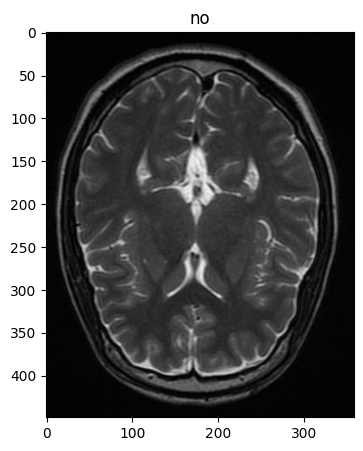

In [20]:
figure = plt.figure(figsize=(5,5))
plt.imshow(plt.imread(Main_Train_Data["jpg"][10]))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][10])

Text(0.5, 1.0, 'yes')

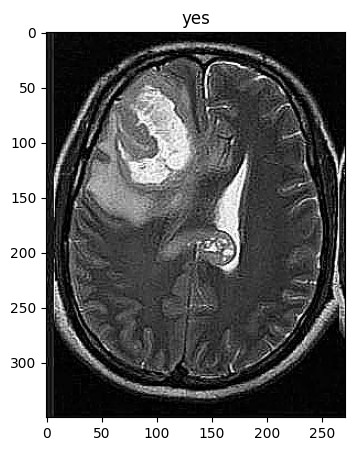

In [21]:
figure = plt.figure(figsize=(5,5))
plt.imshow(plt.imread(Main_Train_Data["jpg"][2996]))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][2996])

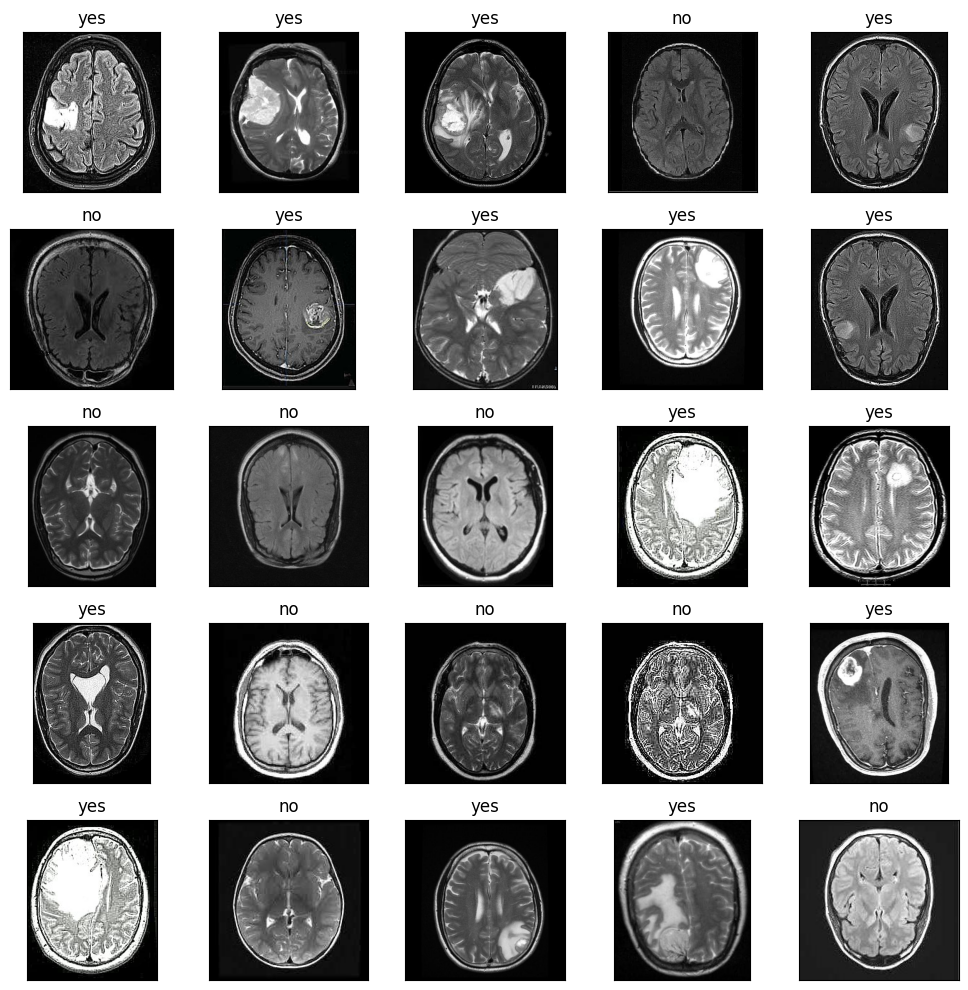

In [22]:
fig, axes = plt.subplots(nrows=5,ncols=5, figsize= (10,10),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["jpg"][i]))
    ax.set_title(Main_Train_Data['TUMOR_CATEGORY'][i])
plt.tight_layout()
plt.show()

# Dataset and DataLoader

In [23]:
class BrainTumorDataset(Dataset):
    def __init__(
        self, 
        metadata_df,  # DataFrame containing image paths
        image_path_column="jpg",  # Column name that contains image paths
        transform=None,
    ):
        """
        Args:
            metadata_df (pd.DataFrame): DataFrame with image paths and labels.
            image_path_column (str): Column name that contains the file paths.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata = metadata_df
        self.image_path_column = image_path_column
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get the image path from the DataFrame's column
        img_name = self.metadata.iloc[idx][self.image_path_column]
        image = Image.open(img_name).convert("RGB")
        label = self.metadata.iloc[idx]["TUMOR_CATEGORY"]
        label = 1 if label == 'yes' else 0  # Convert 'yes' to 1 and 'no' to 0
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [24]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [25]:
train_data,test_data = train_test_split(Main_Train_Data,test_size=0.1, stratify=Main_Train_Data['TUMOR_CATEGORY'])
print(train_data.shape)

(2700, 2)


In [26]:
print(train_data.head())

                                                    jpg TUMOR_CATEGORY
2132  /kaggle/input/brain-tumor-detection/no/no1447.jpg             no
1985  /kaggle/input/brain-tumor-detection/yes/y1020.jpg            yes
1256  /kaggle/input/brain-tumor-detection/no/no1141.jpg             no
630    /kaggle/input/brain-tumor-detection/yes/y372.jpg            yes
438    /kaggle/input/brain-tumor-detection/yes/y601.jpg            yes


In [27]:
print(test_data.shape)
print(test_data.head())

(300, 2)
                                                    jpg TUMOR_CATEGORY
2680   /kaggle/input/brain-tumor-detection/yes/y994.jpg            yes
1598   /kaggle/input/brain-tumor-detection/no/no799.jpg             no
2012   /kaggle/input/brain-tumor-detection/yes/y795.jpg            yes
2455   /kaggle/input/brain-tumor-detection/yes/y801.jpg            yes
1509  /kaggle/input/brain-tumor-detection/no/no1307.jpg             no


In [28]:
train_dataset = BrainTumorDataset(metadata_df=train_data, transform=transform)
test_dataset = BrainTumorDataset(metadata_df=test_data, transform=transform)

In [29]:
# Calculate class weights to balance them

class_counts = train_data['TUMOR_CATEGORY'].value_counts().to_dict()
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[target] for target in train_data['TUMOR_CATEGORY']]

class_weights


{'no': 0.0007407407407407407, 'yes': 0.0007407407407407407}

In [30]:
# The sampler will balance the positive and negative classes in the loader
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [31]:
from sklearn.metrics import roc_curve, auc


def score(solution: np.array, submission: np.array, min_tpr: float=0.80) -> float:

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(solution-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0 * submission

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return partial_auc

In [32]:
# Define a CNN model

class BrainTumorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3)
        self.bn4 = nn.BatchNorm2d(128)

        # Calculate the size of the feature map after the conv and pool layers
        # Input size: 128x128
        # After conv1: (128 - 5 + 1) = 124 -> 124x124
        # After pool1: 124 / 2 = 62 -> 62x62
        # After conv2: (62 - 5 + 1) = 58 -> 58x58
        # After pool2: 58 / 2 = 29 -> 29x29
        # After conv3: (29 - 3 + 1) = 27 -> 27x27
        # After pool3: 27 / 2 = 13.5 -> 13x13 (rounding down)
        # After conv4: (13 - 3 + 1) = 11 -> 11x11
        # After pool4: 11 / 2 = 5.5 -> 5x5 (rounding down)

        self.fc1 = nn.Linear(128 * 5 * 5, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))

        return x
    
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = BrainTumorNet()
model = model.to(device)

Device: cuda:0


In [33]:
# Loss Function and Optimizer

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [34]:
results = []

In [35]:
from tqdm import tqdm
debug = False


# Train the model

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs).flatten()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        n = 5
        if i % n == n-1:    # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss/n:.4f}")
            running_loss = 0.0
        
        if debug:
            if i > n: break
            
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader)):
            images, labels = data[0].to(device), data[1].float().to(device)

            # calculate outputs by running images through the network
            probs = model(images).flatten()
            all_probs.extend(probs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            
            # the class with the highest energy is what we choose as prediction
            predicted = (probs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if debug:
                if i > 3: break
    
    print(len(all_labels), len(all_probs))
    print(all_labels[:5], all_probs[:5])
    accuracy = 100 * correct / total
    print(f"Accuracy of the model: {round(accuracy, 2)} %")
    results.append(round(accuracy, 2))
    print(f"AUC of the model: {score(np.array(all_labels), np.array(all_probs), min_tpr=0.0)}")
    print(f"pAUC-TPR(0.8) of the model: {score(np.array(all_labels), np.array(all_probs))}")

print('Finished Training')

 12%|█▏        | 5/43 [00:04<00:27,  1.37it/s]

[1,     5] loss: 0.6947


 23%|██▎       | 10/43 [00:07<00:20,  1.62it/s]

[1,    10] loss: 0.6908


 35%|███▍      | 15/43 [00:10<00:16,  1.70it/s]

[1,    15] loss: 0.6919


 47%|████▋     | 20/43 [00:12<00:12,  1.91it/s]

[1,    20] loss: 0.6873


 58%|█████▊    | 25/43 [00:15<00:09,  1.95it/s]

[1,    25] loss: 0.6891


 70%|██████▉   | 30/43 [00:17<00:06,  2.10it/s]

[1,    30] loss: 0.6859


 81%|████████▏ | 35/43 [00:20<00:03,  2.04it/s]

[1,    35] loss: 0.6884


 93%|█████████▎| 40/43 [00:22<00:01,  2.28it/s]

[1,    40] loss: 0.6820


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.5477266907691956, 0.5081337690353394, 0.5028670430183411, 0.5425276160240173, 0.49164682626724243]
Accuracy of the model: 60.67 %
AUC of the model: 0.6736888888888888
pAUC-TPR(0.8) of the model: 0.048622222222222206


 12%|█▏        | 5/43 [00:02<00:15,  2.47it/s]

[2,     5] loss: 0.6858


 23%|██▎       | 10/43 [00:04<00:12,  2.55it/s]

[2,    10] loss: 0.6832


 35%|███▍      | 15/43 [00:05<00:11,  2.53it/s]

[2,    15] loss: 0.6782


 47%|████▋     | 20/43 [00:07<00:08,  2.62it/s]

[2,    20] loss: 0.6731


 58%|█████▊    | 25/43 [00:09<00:06,  2.76it/s]

[2,    25] loss: 0.6742


 70%|██████▉   | 30/43 [00:11<00:04,  2.93it/s]

[2,    30] loss: 0.6691


 81%|████████▏ | 35/43 [00:12<00:02,  3.08it/s]

[2,    35] loss: 0.6648


 93%|█████████▎| 40/43 [00:14<00:00,  3.27it/s]

[2,    40] loss: 0.6630


100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.5266227722167969, 0.5069202780723572, 0.4956759810447693, 0.5442898273468018, 0.47673043608665466]
Accuracy of the model: 69.67 %
AUC of the model: 0.7684000000000001
pAUC-TPR(0.8) of the model: 0.09177777777777774


 12%|█▏        | 5/43 [00:01<00:11,  3.44it/s]

[3,     5] loss: 0.6535


 23%|██▎       | 10/43 [00:03<00:10,  3.17it/s]

[3,    10] loss: 0.6524


 35%|███▍      | 15/43 [00:04<00:09,  3.02it/s]

[3,    15] loss: 0.6476


 47%|████▋     | 20/43 [00:06<00:06,  3.42it/s]

[3,    20] loss: 0.6471


 58%|█████▊    | 25/43 [00:07<00:04,  3.70it/s]

[3,    25] loss: 0.6387


 70%|██████▉   | 30/43 [00:09<00:03,  3.57it/s]

[3,    30] loss: 0.6355


 81%|████████▏ | 35/43 [00:10<00:02,  3.25it/s]

[3,    35] loss: 0.6179


 93%|█████████▎| 40/43 [00:11<00:00,  3.57it/s]

[3,    40] loss: 0.6249


100%|██████████| 5/5 [00:01<00:00,  4.27it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.5685225129127502, 0.3856900632381439, 0.5534555315971375, 0.5544590353965759, 0.42037636041641235]
Accuracy of the model: 73.0 %
AUC of the model: 0.7867111111111111
pAUC-TPR(0.8) of the model: 0.08977777777777775


 12%|█▏        | 5/43 [00:01<00:10,  3.74it/s]

[4,     5] loss: 0.6124


 23%|██▎       | 10/43 [00:02<00:08,  3.78it/s]

[4,    10] loss: 0.6099


 35%|███▍      | 15/43 [00:03<00:07,  3.88it/s]

[4,    15] loss: 0.5924


 47%|████▋     | 20/43 [00:05<00:06,  3.75it/s]

[4,    20] loss: 0.5847


 58%|█████▊    | 25/43 [00:06<00:04,  3.77it/s]

[4,    25] loss: 0.5706


 70%|██████▉   | 30/43 [00:07<00:03,  3.92it/s]

[4,    30] loss: 0.5837


 81%|████████▏ | 35/43 [00:09<00:02,  3.75it/s]

[4,    35] loss: 0.5490


 93%|█████████▎| 40/43 [00:10<00:00,  3.80it/s]

[4,    40] loss: 0.5639


100%|██████████| 5/5 [00:01<00:00,  4.38it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.7736077308654785, 0.30515849590301514, 0.5492528676986694, 0.6375135779380798, 0.35592886805534363]
Accuracy of the model: 73.0 %
AUC of the model: 0.8143111111111111
pAUC-TPR(0.8) of the model: 0.09875555555555553


 12%|█▏        | 5/43 [00:01<00:10,  3.67it/s]

[5,     5] loss: 0.5211


 23%|██▎       | 10/43 [00:02<00:08,  3.75it/s]

[5,    10] loss: 0.5408


 35%|███▍      | 15/43 [00:03<00:07,  3.91it/s]

[5,    15] loss: 0.5367


 47%|████▋     | 20/43 [00:05<00:06,  3.46it/s]

[5,    20] loss: 0.5167


 58%|█████▊    | 25/43 [00:06<00:04,  3.77it/s]

[5,    25] loss: 0.4914


 70%|██████▉   | 30/43 [00:08<00:03,  3.64it/s]

[5,    30] loss: 0.4823


 81%|████████▏ | 35/43 [00:09<00:02,  3.88it/s]

[5,    35] loss: 0.5089


 93%|█████████▎| 40/43 [00:10<00:00,  3.99it/s]

[5,    40] loss: 0.4621


100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.8794238567352295, 0.06912300735712051, 0.7152875661849976, 0.7672427296638489, 0.31928983330726624]
Accuracy of the model: 74.67 %
AUC of the model: 0.8318666666666666
pAUC-TPR(0.8) of the model: 0.10702222222222219


 12%|█▏        | 5/43 [00:01<00:10,  3.72it/s]

[6,     5] loss: 0.4752


 23%|██▎       | 10/43 [00:02<00:09,  3.59it/s]

[6,    10] loss: 0.4578


 35%|███▍      | 15/43 [00:04<00:07,  3.96it/s]

[6,    15] loss: 0.4611


 47%|████▋     | 20/43 [00:05<00:05,  3.99it/s]

[6,    20] loss: 0.4807


 58%|█████▊    | 25/43 [00:06<00:04,  4.03it/s]

[6,    25] loss: 0.4815


 70%|██████▉   | 30/43 [00:07<00:03,  3.92it/s]

[6,    30] loss: 0.4620


 81%|████████▏ | 35/43 [00:09<00:02,  3.95it/s]

[6,    35] loss: 0.4816


 93%|█████████▎| 40/43 [00:10<00:00,  3.99it/s]

[6,    40] loss: 0.4628


100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.8571430444717407, 0.06740713864564896, 0.7806030511856079, 0.807679295539856, 0.22582876682281494]
Accuracy of the model: 76.67 %
AUC of the model: 0.8480888888888888
pAUC-TPR(0.8) of the model: 0.11355555555555553


 12%|█▏        | 5/43 [00:01<00:09,  4.14it/s]

[7,     5] loss: 0.4898


 23%|██▎       | 10/43 [00:02<00:08,  3.90it/s]

[7,    10] loss: 0.5106


 35%|███▍      | 15/43 [00:03<00:07,  3.86it/s]

[7,    15] loss: 0.4250


 47%|████▋     | 20/43 [00:05<00:05,  4.02it/s]

[7,    20] loss: 0.4244


 58%|█████▊    | 25/43 [00:06<00:04,  3.99it/s]

[7,    25] loss: 0.4096


 70%|██████▉   | 30/43 [00:07<00:03,  3.98it/s]

[7,    30] loss: 0.4598


 81%|████████▏ | 35/43 [00:08<00:02,  3.89it/s]

[7,    35] loss: 0.4201


 93%|█████████▎| 40/43 [00:10<00:00,  3.84it/s]

[7,    40] loss: 0.3982


100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.9441800117492676, 0.18086762726306915, 0.875999927520752, 0.9101204872131348, 0.31326109170913696]
Accuracy of the model: 79.0 %
AUC of the model: 0.859111111111111
pAUC-TPR(0.8) of the model: 0.1287555555555555


 12%|█▏        | 5/43 [00:01<00:09,  3.81it/s]

[8,     5] loss: 0.3877


 23%|██▎       | 10/43 [00:02<00:08,  3.98it/s]

[8,    10] loss: 0.4369


 35%|███▍      | 15/43 [00:03<00:06,  4.07it/s]

[8,    15] loss: 0.4382


 47%|████▋     | 20/43 [00:05<00:05,  4.01it/s]

[8,    20] loss: 0.3917


 58%|█████▊    | 25/43 [00:06<00:04,  4.01it/s]

[8,    25] loss: 0.4027


 70%|██████▉   | 30/43 [00:07<00:03,  3.87it/s]

[8,    30] loss: 0.3763


 81%|████████▏ | 35/43 [00:08<00:02,  3.92it/s]

[8,    35] loss: 0.3653


 93%|█████████▎| 40/43 [00:10<00:00,  4.02it/s]

[8,    40] loss: 0.3866


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.9698634743690491, 0.0887545719742775, 0.950842559337616, 0.9374916553497314, 0.2916969358921051]
Accuracy of the model: 81.67 %
AUC of the model: 0.8958666666666667
pAUC-TPR(0.8) of the model: 0.13986666666666664


 12%|█▏        | 5/43 [00:01<00:10,  3.79it/s]

[9,     5] loss: 0.3444


 23%|██▎       | 10/43 [00:02<00:08,  3.97it/s]

[9,    10] loss: 0.4025


 35%|███▍      | 15/43 [00:03<00:06,  4.00it/s]

[9,    15] loss: 0.3427


 47%|████▋     | 20/43 [00:05<00:05,  3.84it/s]

[9,    20] loss: 0.3362


 58%|█████▊    | 25/43 [00:06<00:04,  3.87it/s]

[9,    25] loss: 0.3202


 70%|██████▉   | 30/43 [00:07<00:03,  3.95it/s]

[9,    30] loss: 0.3520


 81%|████████▏ | 35/43 [00:08<00:01,  4.15it/s]

[9,    35] loss: 0.3193


 93%|█████████▎| 40/43 [00:10<00:00,  4.01it/s]

[9,    40] loss: 0.3798


100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.9720308780670166, 0.01696055196225643, 0.6090916395187378, 0.9138913750648499, 0.09865827858448029]
Accuracy of the model: 83.33 %
AUC of the model: 0.9158222222222222
pAUC-TPR(0.8) of the model: 0.1461333333333333


 12%|█▏        | 5/43 [00:01<00:09,  3.91it/s]

[10,     5] loss: 0.3229


 23%|██▎       | 10/43 [00:02<00:08,  3.87it/s]

[10,    10] loss: 0.3222


 35%|███▍      | 15/43 [00:03<00:07,  3.65it/s]

[10,    15] loss: 0.3017


 47%|████▋     | 20/43 [00:05<00:05,  4.09it/s]

[10,    20] loss: 0.3100


 58%|█████▊    | 25/43 [00:06<00:04,  3.97it/s]

[10,    25] loss: 0.3103


 70%|██████▉   | 30/43 [00:07<00:03,  3.48it/s]

[10,    30] loss: 0.2586


 81%|████████▏ | 35/43 [00:09<00:02,  3.64it/s]

[10,    35] loss: 0.2594


 93%|█████████▎| 40/43 [00:10<00:00,  3.85it/s]

[10,    40] loss: 0.2820


100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

300 300
[1.0, 0.0, 1.0, 1.0, 0.0] [0.8609616160392761, 0.02449643239378929, 0.7410327196121216, 0.8329813480377197, 0.1399432271718979]
Accuracy of the model: 84.67 %
AUC of the model: 0.9278222222222223
pAUC-TPR(0.8) of the model: 0.15226666666666663
Finished Training
